<ipython-input-5-ebd7a6ae1455>:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Rendimiento_Total': (self.data['Close'][-1] / self.data['Close'][0] - 1) * 100,



Últimas señales de trading:
                                Close     Senal
Date                                           
2025-02-03 00:00:00-05:00  228.009995  MANTENER
2025-02-04 00:00:00-05:00  232.800003  MANTENER
2025-02-05 00:00:00-05:00  232.470001  MANTENER
2025-02-06 00:00:00-05:00  233.220001  MANTENER
2025-02-07 00:00:00-05:00  227.630005  MANTENER

Métricas de rendimiento:
Rendimiento_Total: 21.47%
Rendimiento_Anualizado: 22.40%
Volatilidad_Anual: 23.73%
Ratio_Sharpe: 0.94%


<ipython-input-5-ebd7a6ae1455>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


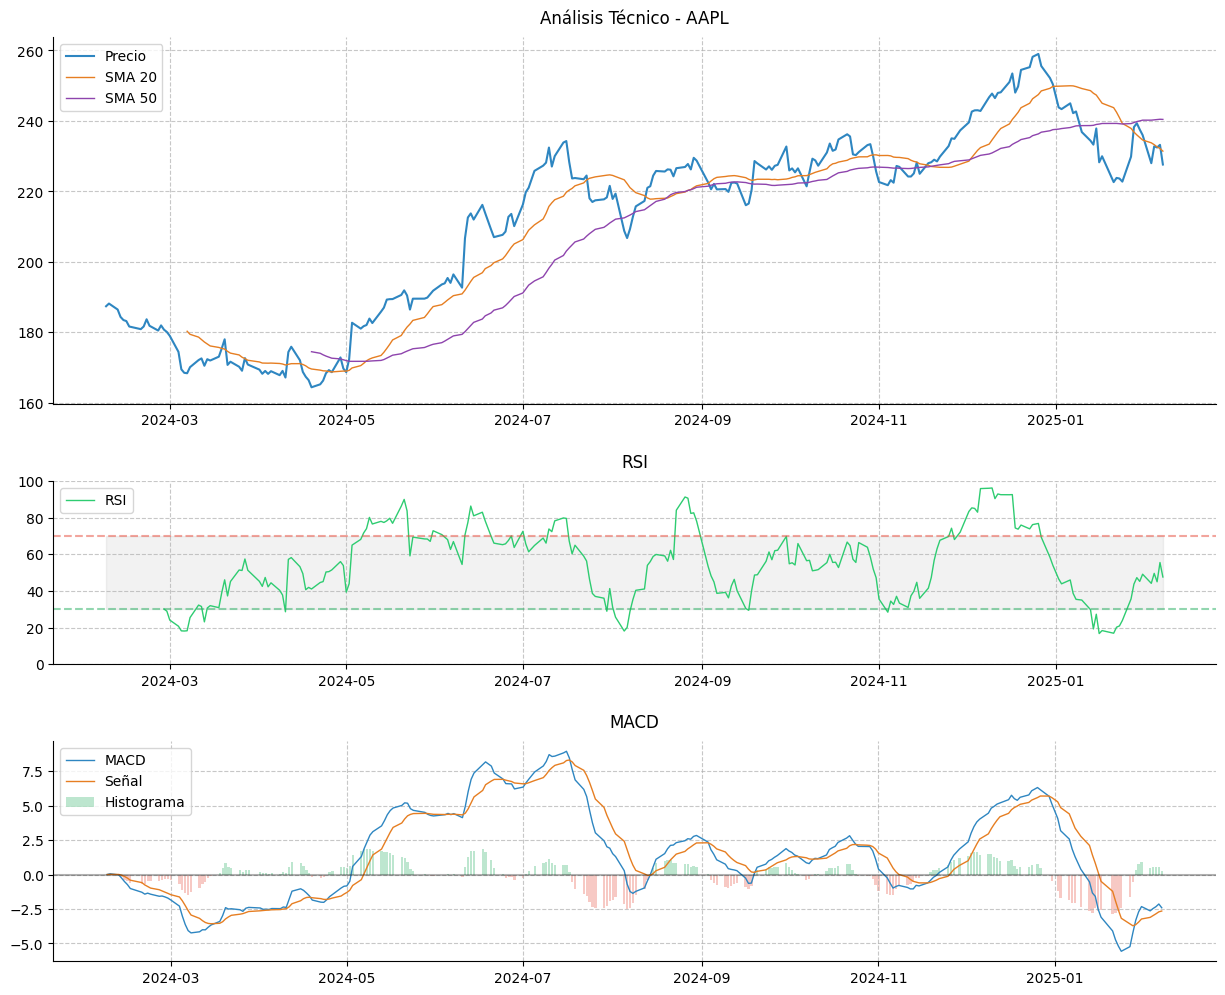

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class AnalizadorFinanciero:
    def __init__(self, simbolo, periodo='1y'):
        """
        Inicializa el analizador con un símbolo y periodo específico
        """
        self.simbolo = simbolo
        self.data = self._obtener_datos(periodo)

    def _obtener_datos(self, periodo):
        """
        Descarga datos históricos usando yfinance
        """
        activo = yf.Ticker(self.simbolo)
        df = activo.history(period=periodo)
        return df

    def calcular_indicadores(self):
        """
        Calcula varios indicadores técnicos
        """
        # Medias móviles
        self.data['SMA_20'] = self.data['Close'].rolling(window=20).mean()
        self.data['SMA_50'] = self.data['Close'].rolling(window=50).mean()

        # RSI
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # Volatilidad (Desviación estándar de rendimientos)
        self.data['Volatilidad'] = self.data['Close'].pct_change().rolling(window=20).std() * np.sqrt(252)

        # MACD
        exp1 = self.data['Close'].ewm(span=12, adjust=False).mean()
        exp2 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = exp1 - exp2
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()
        # Agregamos el histograma del MACD
        self.data['MACD_Histogram'] = self.data['MACD'] - self.data['Signal_Line']

        return self.data

    def generar_senales(self):
        """
        Genera señales de trading basadas en los indicadores
        """
        self.data['Senal'] = 'MANTENER'

        # Señales basadas en cruce de medias móviles
        condicion_compra = (self.data['SMA_20'] > self.data['SMA_50']) & \
                          (self.data['SMA_20'].shift(1) <= self.data['SMA_50'].shift(1))
        condicion_venta = (self.data['SMA_20'] < self.data['SMA_50']) & \
                         (self.data['SMA_20'].shift(1) >= self.data['SMA_50'].shift(1))

        self.data.loc[condicion_compra, 'Senal'] = 'COMPRAR'
        self.data.loc[condicion_venta, 'Senal'] = 'VENDER'

        return self.data

    def analizar_rendimiento(self):
        """
        Calcula métricas de rendimiento
        """
        rendimientos_diarios = self.data['Close'].pct_change()

        metricas = {
            'Rendimiento_Total': (self.data['Close'][-1] / self.data['Close'][0] - 1) * 100,
            'Rendimiento_Anualizado': rendimientos_diarios.mean() * 252 * 100,
            'Volatilidad_Anual': rendimientos_diarios.std() * np.sqrt(252) * 100,
            'Ratio_Sharpe': (rendimientos_diarios.mean() * 252) / (rendimientos_diarios.std() * np.sqrt(252))
        }

        return metricas

    def graficar_analisis(self):
        """
        Genera un gráfico con precio y principales indicadores
        """
        # Configuración del estilo básico de matplotlib
        plt.style.use('default')
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1.2], hspace=0.3)

        # Configuración común para todos los subplots
        def config_subplot(ax, title=None):
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if title:
                ax.set_title(title, fontsize=12, pad=10)

        # Subplot para precio y medias móviles
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.data.index, self.data['Close'], label='Precio', color='#2E86C1', linewidth=1.5)
        ax1.plot(self.data.index, self.data['SMA_20'], label='SMA 20', color='#E67E22', linewidth=1)
        ax1.plot(self.data.index, self.data['SMA_50'], label='SMA 50', color='#8E44AD', linewidth=1)
        config_subplot(ax1, f'Análisis Técnico - {self.simbolo}')
        ax1.legend(loc='upper left', frameon=True)

        # Subplot para RSI
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(self.data.index, self.data['RSI'], label='RSI', color='#2ECC71', linewidth=1)
        ax2.axhline(y=70, color='#E74C3C', linestyle='--', alpha=0.5)
        ax2.axhline(y=30, color='#27AE60', linestyle='--', alpha=0.5)
        ax2.fill_between(self.data.index, 70, 30, alpha=0.1, color='gray')
        ax2.set_ylim(0, 100)
        config_subplot(ax2, 'RSI')
        ax2.legend(loc='upper left', frameon=True)

        # Subplot para MACD con histograma
        ax3 = fig.add_subplot(gs[2])
        # Plotear el histograma
        colors = np.where(self.data['MACD_Histogram'] >= 0, '#27AE60', '#E74C3C')
        ax3.bar(self.data.index, self.data['MACD_Histogram'], color=colors, alpha=0.3, label='Histograma')
        # Plotear líneas MACD y Signal
        ax3.plot(self.data.index, self.data['MACD'], label='MACD', color='#2E86C1', linewidth=1)
        ax3.plot(self.data.index, self.data['Signal_Line'], label='Señal', color='#E67E22', linewidth=1)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        config_subplot(ax3, 'MACD')
        ax3.legend(loc='upper left', frameon=True)

        plt.tight_layout()
        plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    # Crear instancia para AAPL (Apple)
    analizador = AnalizadorFinanciero('AAPL')

    # Calcular indicadores
    datos = analizador.calcular_indicadores()

    # Generar señales
    senales = analizador.generar_senales()

    # Calcular métricas de rendimiento
    metricas = analizador.analizar_rendimiento()

    # Mostrar últimas señales
    print("\nÚltimas señales de trading:")
    print(senales[['Close', 'Senal']].tail())

    # Mostrar métricas
    print("\nMétricas de rendimiento:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.2f}%")

    # Generar gráfico
    analizador.graficar_analisis()

<ipython-input-6-c543dad173e9>:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Rendimiento_Total': (self.data['Close'][-1] / self.data['Close'][0] - 1) * 100,



Últimas señales de trading:
                                Close     Senal
Date                                           
2025-02-03 00:00:00-05:00  228.009995  MANTENER
2025-02-04 00:00:00-05:00  232.800003  MANTENER
2025-02-05 00:00:00-05:00  232.470001  MANTENER
2025-02-06 00:00:00-05:00  233.220001  MANTENER
2025-02-07 00:00:00-05:00  227.630005  MANTENER

Métricas de rendimiento:
Rendimiento_Total: 21.47%
Rendimiento_Anualizado: 22.40%
Volatilidad_Anual: 23.73%
Ratio_Sharpe: 0.94%


<ipython-input-6-c543dad173e9>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


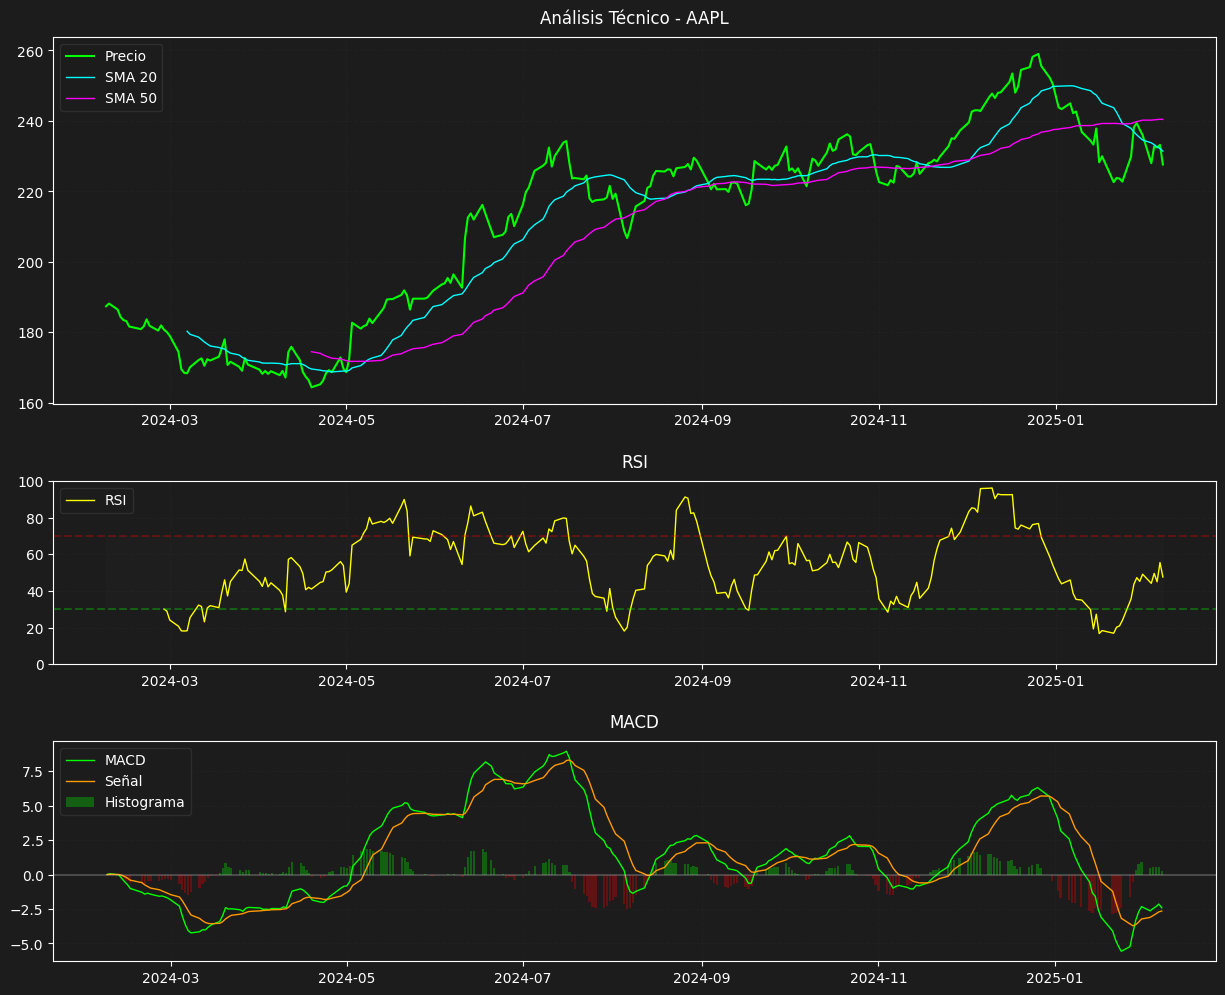

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class AnalizadorFinanciero:
    def __init__(self, simbolo, periodo='1y'):
        self.simbolo = simbolo
        self.data = self._obtener_datos(periodo)

    def _obtener_datos(self, periodo):
        activo = yf.Ticker(self.simbolo)
        df = activo.history(period=periodo)
        return df

    def calcular_indicadores(self):
        # El código de los indicadores permanece igual
        self.data['SMA_20'] = self.data['Close'].rolling(window=20).mean()
        self.data['SMA_50'] = self.data['Close'].rolling(window=50).mean()

        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        self.data['Volatilidad'] = self.data['Close'].pct_change().rolling(window=20).std() * np.sqrt(252)

        exp1 = self.data['Close'].ewm(span=12, adjust=False).mean()
        exp2 = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = exp1 - exp2
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()
        self.data['MACD_Histogram'] = self.data['MACD'] - self.data['Signal_Line']

        return self.data

    def generar_senales(self):
        # El código de las señales permanece igual
        self.data['Senal'] = 'MANTENER'

        condicion_compra = (self.data['SMA_20'] > self.data['SMA_50']) & \
                          (self.data['SMA_20'].shift(1) <= self.data['SMA_50'].shift(1))
        condicion_venta = (self.data['SMA_20'] < self.data['SMA_50']) & \
                         (self.data['SMA_20'].shift(1) >= self.data['SMA_50'].shift(1))

        self.data.loc[condicion_compra, 'Senal'] = 'COMPRAR'
        self.data.loc[condicion_venta, 'Senal'] = 'VENDER'

        return self.data

    def analizar_rendimiento(self):
        # El código de análisis de rendimiento permanece igual
        rendimientos_diarios = self.data['Close'].pct_change()

        metricas = {
            'Rendimiento_Total': (self.data['Close'][-1] / self.data['Close'][0] - 1) * 100,
            'Rendimiento_Anualizado': rendimientos_diarios.mean() * 252 * 100,
            'Volatilidad_Anual': rendimientos_diarios.std() * np.sqrt(252) * 100,
            'Ratio_Sharpe': (rendimientos_diarios.mean() * 252) / (rendimientos_diarios.std() * np.sqrt(252))
        }

        return metricas

    def graficar_analisis(self):
        """
        Genera un gráfico con precio y principales indicadores en tema oscuro
        """
        # Configuración del tema oscuro
        plt.style.use('dark_background')

        # Colores para el tema oscuro
        colors = {
            'precio': '#00ff00',      # Verde brillante para el precio
            'sma20': '#00ffff',       # Cyan para SMA20
            'sma50': '#ff00ff',       # Magenta para SMA50
            'rsi': '#ffff00',         # Amarillo para RSI
            'macd': '#00ff00',        # Verde para MACD
            'signal': '#ff9900',      # Naranja para la línea de señal
            'hist_pos': '#00ff00',    # Verde para histograma positivo
            'hist_neg': '#ff0000',    # Rojo para histograma negativo
            'grid': '#333333'         # Gris oscuro para la grilla
        }

        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1.2], hspace=0.3)

        # Configuración común para todos los subplots
        def config_subplot(ax, title=None):
            ax.grid(True, linestyle='--', alpha=0.2, color=colors['grid'])
            ax.set_facecolor('#1C1C1C')  # Fondo negro grisáceo
            if title:
                ax.set_title(title, fontsize=12, pad=10, color='white')

        # Subplot para precio y medias móviles
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.data.index, self.data['Close'], label='Precio', color=colors['precio'], linewidth=1.5)
        ax1.plot(self.data.index, self.data['SMA_20'], label='SMA 20', color=colors['sma20'], linewidth=1)
        ax1.plot(self.data.index, self.data['SMA_50'], label='SMA 50', color=colors['sma50'], linewidth=1)
        config_subplot(ax1, f'Análisis Técnico - {self.simbolo}')
        ax1.legend(loc='upper left', frameon=True, facecolor='#1C1C1C', edgecolor='#333333')

        # Subplot para RSI
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(self.data.index, self.data['RSI'], label='RSI', color=colors['rsi'], linewidth=1)
        ax2.axhline(y=70, color='#ff0000', linestyle='--', alpha=0.3)
        ax2.axhline(y=30, color='#00ff00', linestyle='--', alpha=0.3)
        ax2.fill_between(self.data.index, 70, 30, alpha=0.1, color='#333333')
        ax2.set_ylim(0, 100)
        config_subplot(ax2, 'RSI')
        ax2.legend(loc='upper left', frameon=True, facecolor='#1C1C1C', edgecolor='#333333')

        # Subplot para MACD con histograma
        ax3 = fig.add_subplot(gs[2])
        # Plotear el histograma
        colors_hist = np.where(self.data['MACD_Histogram'] >= 0, colors['hist_pos'], colors['hist_neg'])
        ax3.bar(self.data.index, self.data['MACD_Histogram'], color=colors_hist, alpha=0.3, label='Histograma')
        # Plotear líneas MACD y Signal
        ax3.plot(self.data.index, self.data['MACD'], label='MACD', color=colors['macd'], linewidth=1)
        ax3.plot(self.data.index, self.data['Signal_Line'], label='Señal', color=colors['signal'], linewidth=1)
        ax3.axhline(y=0, color='white', linestyle='-', alpha=0.2)
        config_subplot(ax3, 'MACD')
        ax3.legend(loc='upper left', frameon=True, facecolor='#1C1C1C', edgecolor='#333333')

        # Configuración del fondo general
        fig.patch.set_facecolor('#1C1C1C')

        plt.tight_layout()
        plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    # Crear instancia para AAPL (Apple)
    analizador = AnalizadorFinanciero('AAPL')

    # Calcular indicadores
    datos = analizador.calcular_indicadores()

    # Generar señales
    senales = analizador.generar_senales()

    # Calcular métricas de rendimiento
    metricas = analizador.analizar_rendimiento()

    # Mostrar últimas señales
    print("\nÚltimas señales de trading:")
    print(senales[['Close', 'Senal']].tail())

    # Mostrar métricas
    print("\nMétricas de rendimiento:")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.2f}%")

    # Generar gráfico
    analizador.graficar_analisis()

<ipython-input-1-ea7da10c6d45>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


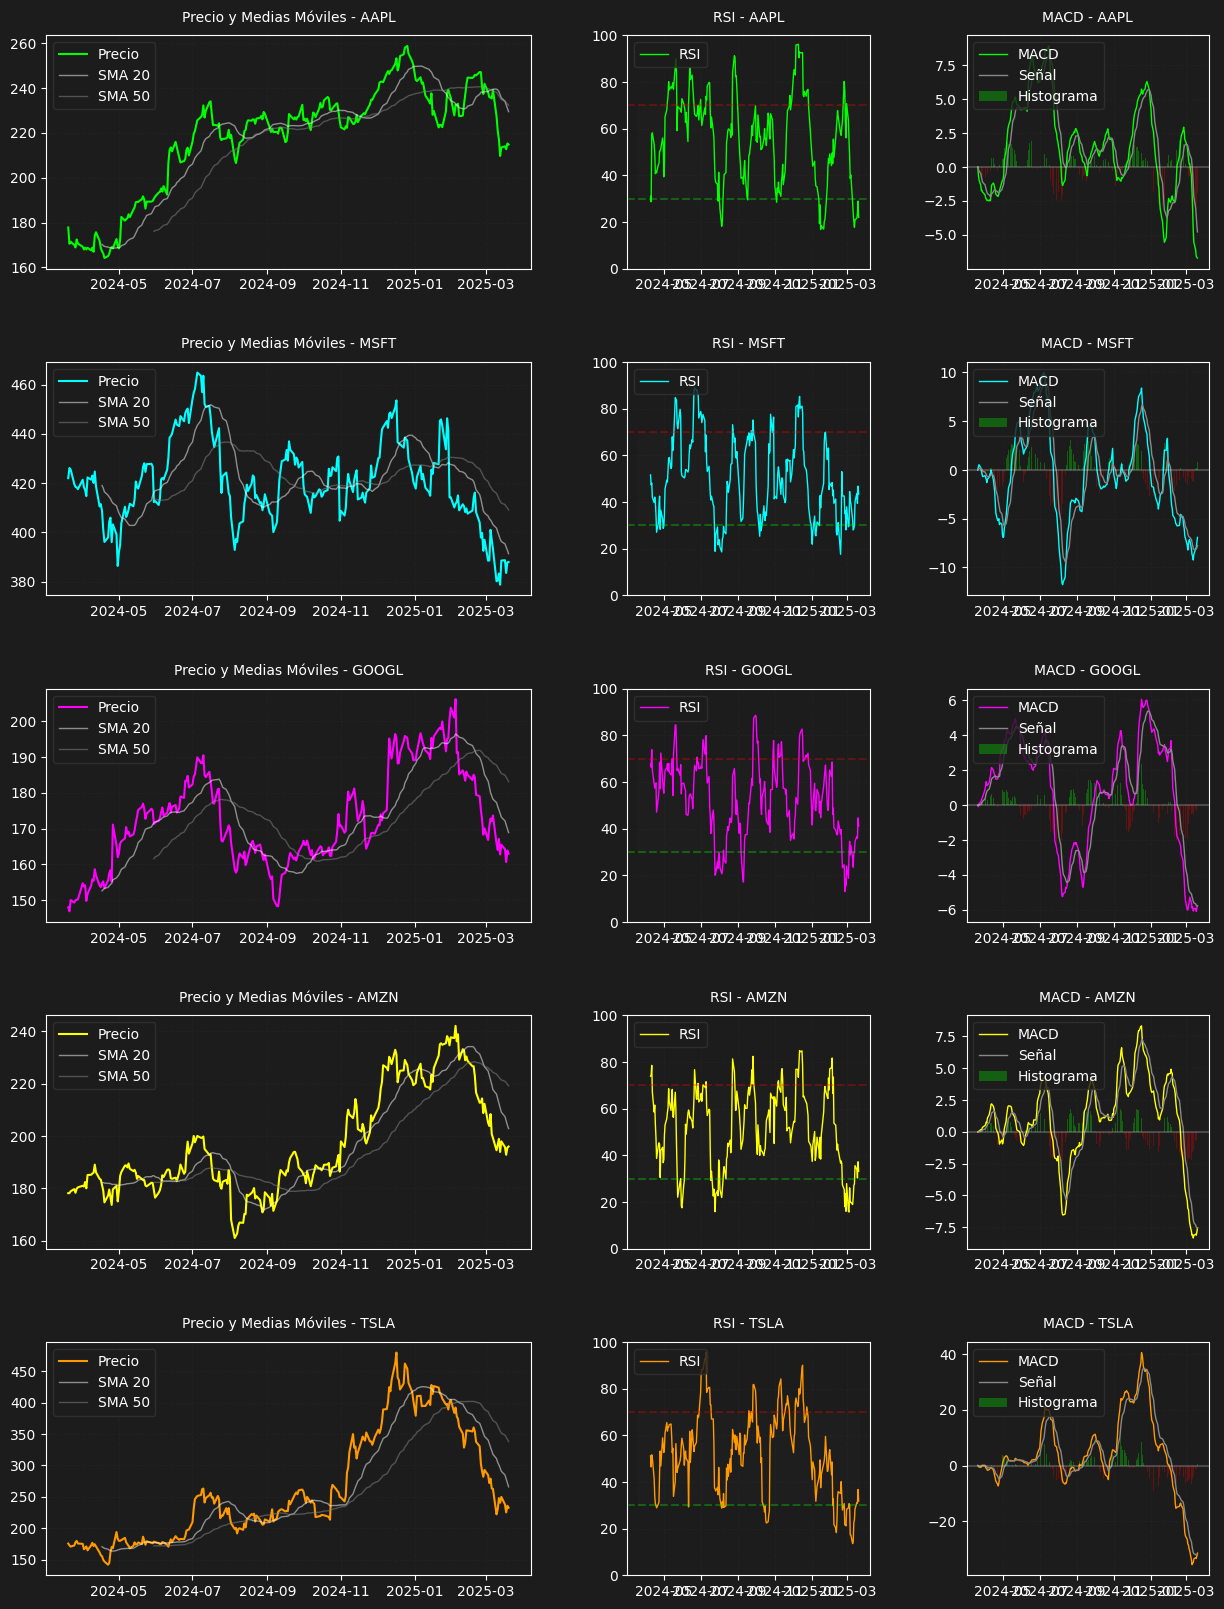


Métricas de Rendimiento:
       Rendimiento_Total  Rendimiento_Anualizado  Volatilidad_Anual  \
AAPL               20.78                   22.10              24.81   
MSFT               -8.07                   -6.18              21.39   
GOOGL              10.10                   13.82              28.78   
AMZN               10.00                   13.53              27.98   
TSLA               32.51                   50.80              67.63   

       Ratio_Sharpe  
AAPL           0.89  
MSFT          -0.29  
GOOGL          0.48  
AMZN           0.48  
TSLA           0.75  


<ipython-input-1-ea7da10c6d45>:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Rendimiento_Total': (df['Close'][-1] / df['Close'][0] - 1) * 100,


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class AnalizadorFinanciero:
    def __init__(self, simbolos, periodo='1y'):
        """
        Inicializa el analizador con múltiples símbolos
        """
        if isinstance(simbolos, str):
            simbolos = [simbolos]
        self.simbolos = simbolos
        self.datos = {}
        for simbolo in simbolos:
            self.datos[simbolo] = self._obtener_datos(simbolo, periodo)

    def _obtener_datos(self, simbolo, periodo):
        """
        Descarga datos históricos para un símbolo
        """
        activo = yf.Ticker(simbolo)
        df = activo.history(period=periodo)
        return df

    def calcular_indicadores(self):
        """
        Calcula indicadores técnicos para todos los activos
        """
        for simbolo in self.simbolos:
            df = self.datos[simbolo]

            # Medias móviles
            df['SMA_20'] = df['Close'].rolling(window=20).mean()
            df['SMA_50'] = df['Close'].rolling(window=50).mean()

            # RSI
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            df['RSI'] = 100 - (100 / (1 + rs))

            # MACD
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = exp1 - exp2
            df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

            self.datos[simbolo] = df

        return self.datos

    def analizar_rendimiento(self):
        """
        Calcula métricas de rendimiento para todos los activos
        """
        metricas = {}
        for simbolo in self.simbolos:
            df = self.datos[simbolo]
            rendimientos_diarios = df['Close'].pct_change()

            metricas[simbolo] = {
                'Rendimiento_Total': (df['Close'][-1] / df['Close'][0] - 1) * 100,
                'Rendimiento_Anualizado': rendimientos_diarios.mean() * 252 * 100,
                'Volatilidad_Anual': rendimientos_diarios.std() * np.sqrt(252) * 100,
                'Ratio_Sharpe': (rendimientos_diarios.mean() * 252) / (rendimientos_diarios.std() * np.sqrt(252))
            }

        return metricas

    def graficar_analisis(self):
        """
        Genera gráficos para todos los activos
        """
        # Configuración del tema oscuro
        plt.style.use('dark_background')

        # Colores para cada activo
        colores_activos = ['#00ff00', '#00ffff', '#ff00ff', '#ffff00', '#ff9900']

        # Crear subplots para cada tipo de análisis
        n_activos = len(self.simbolos)
        fig = plt.figure(figsize=(15, 4 * n_activos))
        gs = fig.add_gridspec(n_activos, 3, width_ratios=[2, 1, 1], hspace=0.4, wspace=0.3)

        for idx, simbolo in enumerate(self.simbolos):
            df = self.datos[simbolo]
            color_base = colores_activos[idx % len(colores_activos)]

            # Configuración común para los subplots
            def config_subplot(ax, title):
                ax.grid(True, linestyle='--', alpha=0.2, color='#333333')
                ax.set_facecolor('#1C1C1C')
                ax.set_title(f'{title} - {simbolo}', fontsize=10, pad=10, color='white')
                ax.legend(loc='upper left', frameon=True, facecolor='#1C1C1C', edgecolor='#333333')

            # Precio y SMA
            ax1 = fig.add_subplot(gs[idx, 0])
            ax1.plot(df.index, df['Close'], label='Precio', color=color_base, linewidth=1.5)
            ax1.plot(df.index, df['SMA_20'], label='SMA 20', color='#ffffff', linewidth=1, alpha=0.5)
            ax1.plot(df.index, df['SMA_50'], label='SMA 50', color='#888888', linewidth=1, alpha=0.5)
            config_subplot(ax1, 'Precio y Medias Móviles')

            # RSI
            ax2 = fig.add_subplot(gs[idx, 1])
            ax2.plot(df.index, df['RSI'], label='RSI', color=color_base, linewidth=1)
            ax2.axhline(y=70, color='#ff0000', linestyle='--', alpha=0.3)
            ax2.axhline(y=30, color='#00ff00', linestyle='--', alpha=0.3)
            ax2.fill_between(df.index, 70, 30, alpha=0.1, color='#333333')
            ax2.set_ylim(0, 100)
            config_subplot(ax2, 'RSI')

            # MACD
            ax3 = fig.add_subplot(gs[idx, 2])
            colors_hist = np.where(df['MACD_Histogram'] >= 0, '#00ff00', '#ff0000')
            ax3.bar(df.index, df['MACD_Histogram'], color=colors_hist, alpha=0.3, label='Histograma')
            ax3.plot(df.index, df['MACD'], label='MACD', color=color_base, linewidth=1)
            ax3.plot(df.index, df['Signal_Line'], label='Señal', color='#888888', linewidth=1)
            ax3.axhline(y=0, color='white', linestyle='-', alpha=0.2)
            config_subplot(ax3, 'MACD')

        # Configuración del fondo general
        fig.patch.set_facecolor('#1C1C1C')
        plt.tight_layout()
        plt.show()

        # Mostrar métricas de rendimiento
        self._mostrar_metricas()

    def _mostrar_metricas(self):
        """
        Muestra las métricas de rendimiento en formato tabular
        """
        metricas = self.analizar_rendimiento()
        df_metricas = pd.DataFrame(metricas).T
        print("\nMétricas de Rendimiento:")
        print(df_metricas.round(2))

# Ejemplo de uso
if __name__ == "__main__":
    # Lista de símbolos a analizar
    simbolos = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

    # Crear instancia del analizador
    analizador = AnalizadorFinanciero(simbolos)

    # Calcular indicadores
    datos = analizador.calcular_indicadores()

    # Generar gráficos y mostrar métricas
    analizador.graficar_analisis()

<ipython-input-7-c25e63541cb9>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


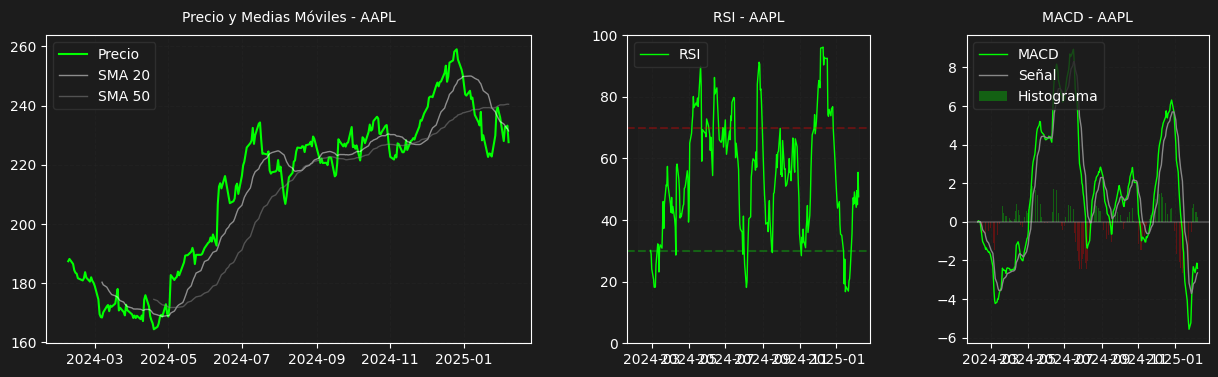


Métricas de Rendimiento:
      Rendimiento_Total  Rendimiento_Anualizado  Volatilidad_Anual  \
AAPL              21.47                    22.4              23.73   

      Ratio_Sharpe  
AAPL          0.94  


<ipython-input-7-c25e63541cb9>:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Rendimiento_Total': (df['Close'][-1] / df['Close'][0] - 1) * 100,


In [ ]:
simbolos = 'AAPL'

# Crear instancia del analizador
analizador = AnalizadorFinanciero('AAPL')

# Calcular indicadores
datos = analizador.calcular_indicadores()

# Generar gráficos y mostrar métricas
analizador.graficar_analisis()